<a href="https://colab.research.google.com/github/iamfaham/stock-data-linear-regression/blob/main/stock_data_linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install yfinance

In [40]:
import yfinance as yf
import pandas as pd

# Define the ticker symbol and the date range
ticker_symbol = "AAPL"  # Example: Apple Inc.
start_date = "2020-01-01"
end_date = "2025-07-01" # Data up to June 30th, 2025

# Download the data
stock_data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Display the first few rows of the data
display(stock_data.head())

/tmp/ipython-input-1533961218.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(ticker_symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,
2020-01-02,5.971746,5.971746,5.892343,5.942872,237536000
2020-01-03,5.876164,5.919973,5.827127,5.852019,205384000
2020-01-06,5.900805,5.906032,5.756683,5.782819,262636000
2020-01-07,5.972244,6.018044,5.884127,5.929181,314856000
2020-01-08,5.983445,6.024765,5.927937,5.968012,277108000


In [41]:
# Calculate moving averages
stock_data['SMA_20'] = stock_data['Close'].rolling(window=20).mean()
stock_data['SMA_50'] = stock_data['Close'].rolling(window=50).mean()

# Flatten the multi-level column index
stock_data.columns = stock_data.columns.get_level_values(0)

# Display the updated DataFrame with new features and flattened index
display(stock_data.head())

Price,Close,High,Low,Open,Volume,SMA_20,SMA_50
Date,,,,,,,
2020-01-02,5.971746,5.971746,5.892343,5.942872,237536000,NaN,NaN
2020-01-03,5.876164,5.919973,5.827127,5.852019,205384000,NaN,NaN
2020-01-06,5.900805,5.906032,5.756683,5.782819,262636000,NaN,NaN
2020-01-07,5.972244,6.018044,5.884127,5.929181,314856000,NaN,NaN
2020-01-08,5.983445,6.024765,5.927937,5.968012,277108000,NaN,NaN


In [42]:
import pandas as pd

# Assuming stock_data is already loaded and has the initial columns

# Calculate RSI
def calculate_rsi(data, window):
    delta = data.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

stock_data['RSI'] = calculate_rsi(stock_data['Close'], window=14)

# Calculate MACD
exp12 = stock_data['Close'].ewm(span=12, adjust=False).mean()
exp26 = stock_data['Close'].ewm(span=26, adjust=False).mean()
stock_data['MACD'] = exp12 - exp26
stock_data['MACD_Signal'] = stock_data['MACD'].ewm(span=9, adjust=False).mean()

# Calculate Bollinger Band component (20-day rolling standard deviation)
stock_data['BB_StdDev'] = stock_data['Close'].rolling(window=20).std()

# Calculate 20-day rolling average of Volume
stock_data['Volume_Avg'] = stock_data['Volume'].rolling(window=20).mean()

# Drop rows with NaN values created by moving averages and new features
stock_data.dropna(inplace=True)

# Display the updated DataFrame with new features and flattened index
display(stock_data.head())

Price,Close,High,Low,Open,Volume,SMA_20,SMA_50,RSI,MACD,MACD_Signal,BB_StdDev,Volume_Avg
Date,,,,,,,,,,,,
2020-03-13,5.998482,6.002965,5.469717,5.740948,634836000,6.730236,6.405579,42.267575,-0.139963,0.004222,0.592854,748864800.0
2020-03-16,4.891637,5.631361,4.831862,5.290390,726972000,6.614151,6.383977,36.464200,-0.244576,-0.045538,0.709172,733117200.0
2020-03-17,5.411434,5.500849,4.757141,5.003964,833632000,6.515617,6.374683,40.237146,-0.282285,-0.092887,0.733347,743790600.0
2020-03-18,5.051537,5.228871,4.500107,4.983791,874268000,6.376525,6.357697,40.306101,-0.337322,-0.141774,0.734067,752787400.0
2020-03-19,5.304338,5.397986,4.816668,5.030117,765512000,6.257539,6.344339,38.554330,-0.356431,-0.184705,0.703191,750560400.0


In [43]:
from sklearn.model_selection import train_test_split
import pandas as pd # Import pandas to use Timestamp

# Define features (X) and target (y)
features = ['SMA_20', 'SMA_50', 'RSI', 'MACD', 'MACD_Signal', 'BB_StdDev', 'Volume_Avg']
target = 'Close'

X = stock_data[features]
y = stock_data[target]

# Split data based on date: train up to Jan 2025, test from Feb to Jun 2025
train_end_date = pd.Timestamp('2025-01-31')

X_train = X[X.index <= train_end_date]
y_train = y[y.index <= train_end_date]
X_test = X[X.index > train_end_date]
y_test = y[y.index > train_end_date]

# Print the shapes of the new sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (1229, 7) (1229,)
Testing set shape: (102, 7) (102,)


In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Define and train Linear Regression model
lr_model = LinearRegression()
print("Training Linear Regression...")
lr_model.fit(X_train, y_train)
print("Model training complete.\n")

# Make predictions and evaluate
y_pred_lr = lr_model.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

# Print evaluation metrics
print("Linear Regression:")
print(f"Mean Squared Error (MSE): {mse_lr:.4f}")
print(f"R-squared (R2) Score: {r2_lr:.4f}\n")

Training Linear Regression...
Model training complete.

Linear Regression:
Mean Squared Error (MSE): 7.2785
R-squared (R2) Score: 0.9688



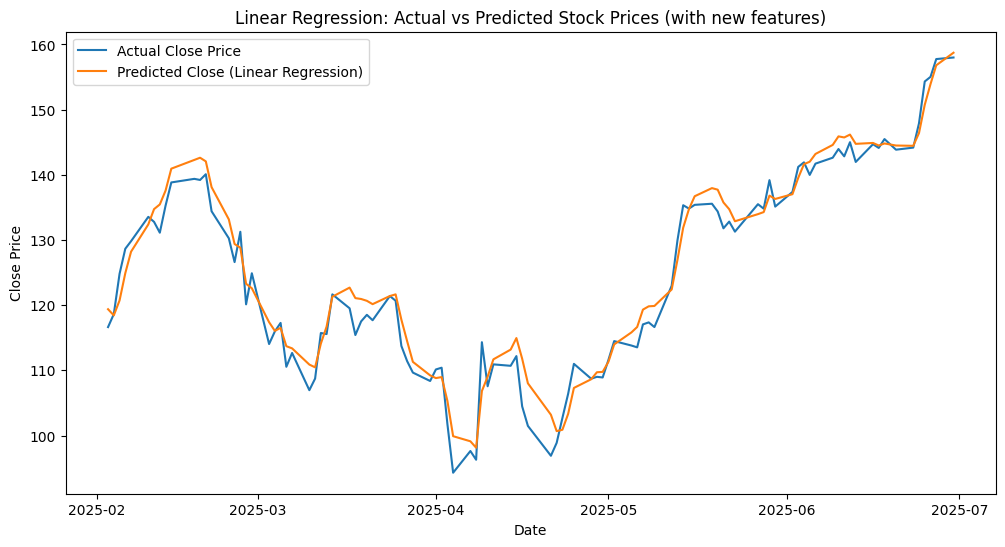

In [45]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have the trained lr_model from previous steps
# And y_test, X_test are the test sets with the new features

# Make predictions on the test set
y_pred_lr = lr_model.predict(X_test)

# Create DataFrame for predictions
predictions_lr_df = pd.DataFrame({'Actual Close': y_test.values.flatten(), 'Predicted Close (Linear Regression)': y_pred_lr.flatten()}, index=X_test.index)

# Plot actual vs predicted prices for Linear Regression
plt.figure(figsize=(12, 6))
predictions_lr_df_sorted = predictions_lr_df.sort_index()
plt.plot(predictions_lr_df_sorted.index, predictions_lr_df_sorted['Actual Close'], label='Actual Close Price')
plt.plot(predictions_lr_df_sorted.index, predictions_lr_df_sorted['Predicted Close (Linear Regression)'], label='Predicted Close (Linear Regression)')
plt.title('Linear Regression: Actual vs Predicted Stock Prices (with new features)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()